In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from dyck_k_generator import constants

In [3]:
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'cuda:0'

In [4]:
if device == "mps":
    torch.mps.empty_cache()
elif device == "cuda:0":
    torch.cuda.empty_cache()

In [5]:
torch.manual_seed(42)

In [6]:
k = 1

In [7]:
from dyck_k_generator.generator import generate_dataset

path = generate_dataset(
    n=1000,
    k=k,
    max_length=10,
    balanced=0.55,
)

Generating unbalanced strings: 100%|██████████| 450/450 [00:00<00:00, 71447.81it/s]
Saving dataset to data/dyck-1_1000-samples_10-len_p055.jsonl: 100%|██████████| 1000/1000 [00:00<00:00, 532272.08it/s]

Dataset saved to data/dyck-1_1000-samples_10-len_p055.jsonl


In [8]:
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

'()'

In [9]:
from dataset.dataset import DyckLanguageDataset

In [10]:
dataset = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 1000 samples from data/dyck-1_1000-samples_10-len_p055.jsonl


Tokenizing strings: 100%|██████████| 1000/1000 [00:00<00:00, 560286.40it/s]


In [11]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

In [12]:
from torch.utils.data import DataLoader

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Manual Transformer + BERTViz


In [14]:
from transformer.hooked_transformer import (
    TransformerClassifier,
    TransformerClassifierConfig,
    causal_mask,
    pad_token_mask,
)

In [15]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=384,
    n_layers=1,
    n_classes=2,
    max_seq_len=10,
)

In [16]:
model_bidirectional = TransformerClassifier(model_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasmolinolo. Use `wandb login --relogin` to force relogin


In [17]:
model_bidirectional.to(device)

TransformerClassifier(
  (embedding): Embedding(5, 256)
  (pos_encoder): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=384, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=384, out_features=256, bias=True)
        )
        (ln1): La

In [18]:
import torch.optim as optim

crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_bidirectional.parameters(), lr=1e-4)

In [19]:
train_loss, train_acc, val_loss, val_acc = model_bidirectional.train_model(
    device=device,
    epochs=20,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0970 | Train Acc: 53.00%
Val Loss: 1.3673 | Val Acc: 53.33%
Epoch 2/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1090 | Train Acc: 52.75%
Val Loss: 1.3347 | Val Acc: 53.33%
Epoch 3/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.8813 | Train Acc: 55.00%
Val Loss: 1.3639 | Val Acc: 53.33%
Epoch 4/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9928 | Train Acc: 54.12%
Val Loss: 1.3141 | Val Acc: 45.83%
Epoch 5/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9479 | Train Acc: 51.00%
Val Loss: 1.2836 | Val Acc: 61.67%
Epoch 6/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.8133 | Train Acc: 55.00%
Val Loss: 1.3281 | Val Acc: 69.17%
Epoch 7/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9799 | Train Acc: 53.00%
Val Loss: 1.3734 | Val Acc: 54.17%
Epoch 8/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.7097 | Train Acc: 56.12%
Val Loss: 1.0634 | Val Acc: 100.00%
Epoch 9/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 5.0005 | Train Acc: 89.50%
Val Loss: 0.4332 | Val Acc: 100.00%
Epoch 10/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 1.4601 | Train Acc: 99.75%
Val Loss: 0.0533 | Val Acc: 100.00%
Epoch 11/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3185 | Train Acc: 100.00%
Val Loss: 0.0110 | Val Acc: 100.00%
Epoch 12/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1138 | Train Acc: 100.00%
Val Loss: 0.0047 | Val Acc: 100.00%
Epoch 13/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0506 | Train Acc: 100.00%
Val Loss: 0.0028 | Val Acc: 100.00%
Epoch 14/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0342 | Train Acc: 100.00%
Val Loss: 0.0022 | Val Acc: 100.00%
Epoch 15/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0266 | Train Acc: 100.00%
Val Loss: 0.0017 | Val Acc: 100.00%
Epoch 16/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0216 | Train Acc: 100.00%
Val Loss: 0.0013 | Val Acc: 100.00%
Epoch 17/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0191 | Train Acc: 100.00%
Val Loss: 0.0010 | Val Acc: 100.00%
Epoch 18/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0145 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 19/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0105 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%
Epoch 20/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0085 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%


In [20]:
test_loss, test_acc = model_bidirectional.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.0021 | Test Acc: 100.00%


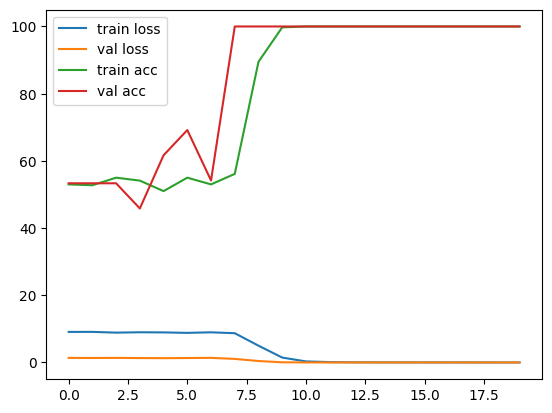

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

In [22]:
model_causal = TransformerClassifier(model_config).to(device)

train_acc,▂▂▂▁▂▂▂▂▂▁▁▂▁▂▁▂▄▆██████████████████████
train_loss,███▇██▇█▇▇█▇█▇█▇▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▂▂▂▂▁▁▃▄▄▃▂████████████████████████████
val_loss,███████▇████▆▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,100.0
train_loss,0.00053
val_acc,100.0
val_loss,0.00015


In [23]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_causal.parameters(), lr=1e-4)

In [24]:
train_loss, train_acc, val_loss, val_acc = model_causal.train_model(
    device=device,
    epochs=50,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="causal",
)

Epoch 1/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.2018 | Train Acc: 53.75%
Val Loss: 1.3925 | Val Acc: 53.33%
Epoch 2/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.2495 | Train Acc: 50.00%
Val Loss: 1.3857 | Val Acc: 53.33%
Epoch 3/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1799 | Train Acc: 51.25%
Val Loss: 1.3820 | Val Acc: 53.33%
Epoch 4/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1204 | Train Acc: 50.75%
Val Loss: 1.3930 | Val Acc: 53.33%
Epoch 5/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1075 | Train Acc: 50.25%
Val Loss: 1.3834 | Val Acc: 53.33%
Epoch 6/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0349 | Train Acc: 53.00%
Val Loss: 1.3856 | Val Acc: 53.33%
Epoch 7/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1768 | Train Acc: 51.25%
Val Loss: 1.3863 | Val Acc: 53.33%
Epoch 8/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1274 | Train Acc: 51.00%
Val Loss: 1.3996 | Val Acc: 53.33%
Epoch 9/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1706 | Train Acc: 51.50%
Val Loss: 1.3868 | Val Acc: 53.33%
Epoch 10/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0822 | Train Acc: 51.62%
Val Loss: 1.3918 | Val Acc: 53.33%
Epoch 11/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0017 | Train Acc: 53.37%
Val Loss: 1.3820 | Val Acc: 53.33%
Epoch 12/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0791 | Train Acc: 51.25%
Val Loss: 1.3919 | Val Acc: 53.33%
Epoch 13/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0887 | Train Acc: 53.12%
Val Loss: 1.3824 | Val Acc: 53.33%
Epoch 14/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1359 | Train Acc: 50.00%
Val Loss: 1.4065 | Val Acc: 53.33%
Epoch 15/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0650 | Train Acc: 53.00%
Val Loss: 1.3843 | Val Acc: 53.33%
Epoch 16/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0034 | Train Acc: 52.25%
Val Loss: 1.3829 | Val Acc: 53.33%
Epoch 17/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0229 | Train Acc: 52.38%
Val Loss: 1.3848 | Val Acc: 53.33%
Epoch 18/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0982 | Train Acc: 52.12%
Val Loss: 1.3819 | Val Acc: 53.33%
Epoch 19/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9693 | Train Acc: 51.00%
Val Loss: 1.3885 | Val Acc: 53.33%
Epoch 20/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0629 | Train Acc: 53.75%
Val Loss: 1.3832 | Val Acc: 53.33%
Epoch 21/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1202 | Train Acc: 52.38%
Val Loss: 1.3879 | Val Acc: 53.33%
Epoch 22/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1038 | Train Acc: 51.38%
Val Loss: 1.3927 | Val Acc: 53.33%
Epoch 23/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0041 | Train Acc: 53.00%
Val Loss: 1.3821 | Val Acc: 53.33%
Epoch 24/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0104 | Train Acc: 52.00%
Val Loss: 1.3864 | Val Acc: 53.33%
Epoch 25/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1007 | Train Acc: 52.38%
Val Loss: 1.3814 | Val Acc: 53.33%
Epoch 26/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0320 | Train Acc: 51.00%
Val Loss: 1.3949 | Val Acc: 53.33%
Epoch 27/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0093 | Train Acc: 53.00%
Val Loss: 1.3816 | Val Acc: 53.33%
Epoch 28/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0340 | Train Acc: 54.00%
Val Loss: 1.3895 | Val Acc: 53.33%
Epoch 29/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0764 | Train Acc: 51.75%
Val Loss: 1.3873 | Val Acc: 46.67%
Epoch 30/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0198 | Train Acc: 51.88%
Val Loss: 1.3875 | Val Acc: 53.33%
Epoch 31/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0447 | Train Acc: 49.25%
Val Loss: 1.3869 | Val Acc: 53.33%
Epoch 32/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0581 | Train Acc: 53.50%
Val Loss: 1.3826 | Val Acc: 53.33%
Epoch 33/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0212 | Train Acc: 53.00%
Val Loss: 1.3829 | Val Acc: 53.33%
Epoch 34/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0606 | Train Acc: 52.62%
Val Loss: 1.3814 | Val Acc: 53.33%
Epoch 35/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9647 | Train Acc: 54.00%
Val Loss: 1.3870 | Val Acc: 53.33%
Epoch 36/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9965 | Train Acc: 55.62%
Val Loss: 1.3818 | Val Acc: 53.33%
Epoch 37/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0348 | Train Acc: 53.12%
Val Loss: 1.3821 | Val Acc: 53.33%
Epoch 38/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9842 | Train Acc: 54.75%
Val Loss: 1.3845 | Val Acc: 53.33%
Epoch 39/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9670 | Train Acc: 52.38%
Val Loss: 1.3837 | Val Acc: 53.33%
Epoch 40/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0217 | Train Acc: 51.75%
Val Loss: 1.3851 | Val Acc: 53.33%
Epoch 41/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0088 | Train Acc: 50.75%
Val Loss: 1.3894 | Val Acc: 53.33%
Epoch 42/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0252 | Train Acc: 54.25%
Val Loss: 1.3833 | Val Acc: 53.33%
Epoch 43/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0813 | Train Acc: 50.50%
Val Loss: 1.3832 | Val Acc: 53.33%
Epoch 44/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0118 | Train Acc: 54.37%
Val Loss: 1.3823 | Val Acc: 53.33%
Epoch 45/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0305 | Train Acc: 54.25%
Val Loss: 1.3813 | Val Acc: 53.33%
Epoch 46/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9969 | Train Acc: 54.37%
Val Loss: 1.3813 | Val Acc: 53.33%
Epoch 47/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0569 | Train Acc: 49.88%
Val Loss: 1.3913 | Val Acc: 53.33%
Epoch 48/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0221 | Train Acc: 53.50%
Val Loss: 1.3814 | Val Acc: 53.33%
Epoch 49/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9819 | Train Acc: 54.00%
Val Loss: 1.3824 | Val Acc: 53.33%
Epoch 50/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0129 | Train Acc: 51.62%
Val Loss: 1.3818 | Val Acc: 53.33%


In [25]:
test_loss, test_acc = model_causal.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 6.8917 | Test Acc: 60.00%


# Attention plots:


In [ ]:
batch = next(iter(test_dataloader))
strings, labels, tokens = batch

mask = causal_mask(tokens)
attn_matrices = model_bidirectional.get_attn_matrices(tokens, mask)

In [ ]:
from transformer_viz.visualizer import min_max_normalize, plot_attn_matrices

In [ ]:
from dataset.dataset import DyckLanguageTokenizer

In [ ]:
batch = (
    ")))))))(((((((",
    True,
    DyckLanguageTokenizer(VOCAB).tokenize(")))))))(((((((").to(device),
)
batch

In [ ]:
plot_attn_matrices(VOCAB, batch, model_bidirectional, min_max_normalize, pad_token_mask)

In [ ]:
minimax_norm = min_max_normalize(attn_matrices[0][0][0].cpu().detach().numpy())

In [ ]:
minimax_norm[0][0]

# Experiment 2

We will experiment with the same grammar, using a causal mask instead of a bidirectional one.


In [ ]:
model_two = TransformerClassifier(model_config).to(device)

# Experiment 3

Dyck-3


In [ ]:
k = 3

In [ ]:
path = generate_dataset(
    n=5_000,
    k=3,
    min_length=8,
    max_length=8,
    balanced=0.6,
)

In [ ]:
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

In [ ]:
dataset_dyck_2 = DyckLanguageDataset(path, VOCAB).to(device)

In [ ]:
train_size = int(0.8 * len(dataset_dyck_2))
val_size = int(0.15 * train_size)
test_size = len(dataset_dyck_2) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset_dyck_2, [train_size, val_size, test_size]
)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=512,
    n_heads=1,
    dim_ff=1024,
    n_layers=3,
    n_classes=2,
    max_seq_len=10,
)

In [ ]:
model = TransformerClassifier(model_config).to(device)

In [ ]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
train_loss, train_acc, val_loss, val_acc = model.train_model(
    device=device,
    epochs=15,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

In [ ]:
test_loss, test_acc = model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

In [ ]:
batch = next(iter(test_dataloader))
batch

In [ ]:
plot_attn_matrices(VOCAB, batch, model, min_max_normalize, pad_token_mask)